## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [137]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

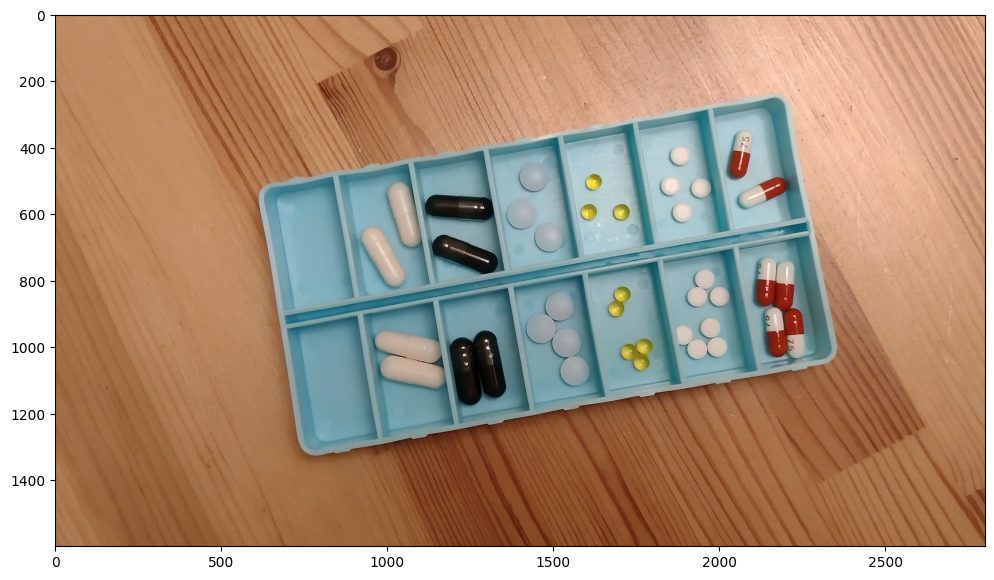

In [138]:
calib = cv2.imread("calib.png")
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(calib[..., ::-1])

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [139]:
class PillType(Enum):
    PROBIO = 1  # duże białe kapsułki
    CARBON = 2  # duże czarne kapsułki
    KETO = 3  # niebieskie tabletki
    ESPU = 4  # małe żółte kapsułki
    BIOX = 5  # małe białe tabletki
    LINE = 6  # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [140]:
class BBox:
    def __init__(self, x: int, y: int, w: int, h: int):
        self.x = x
        self.y = y
        self.w = w
        self.h = h


class Pill:
    """Output of object detection, represents a single instance"""

    def __init__(self, pill_type: PillType, bbox: BBox):
        self.type = pill_type
        self.bbox = bbox

In [141]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

In [142]:
import import_ipynb
from lab5_biox_class import BioxDetector
from lab5_carbon_class import CarbonDetector
from lab5_espu_class import EspuDetector
from lab5_keto_class import KetoDetector
from lab5_probio_class import ProbioDetector

In [143]:
def detect_biox(image):
    results = BioxDetector.segment(image)
    filtered_results = np.unique(results[results > 1])

    pills: List[Pill] = []

    for res_index in filtered_results:
        res = np.zeros_like(results)
        res[results == res_index] = 255
        contours, _ = cv2.findContours(
            res.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        contour = contours[0]
        x, y, w, h = cv2.boundingRect(contour)
        bbox = BBox(x, y, w, h)
        pills.append(Pill(PillType.BIOX, bbox))

    return pills


def detect_from_thresholded(image, thresholder_class, pilltype):
    results = thresholder_class.threshold(image)
    contours, _ = cv2.findContours(
        results.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    pills: List[Pill] = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bbox = BBox(x, y, w, h)
        pills.append(Pill(pilltype, bbox))

    return pills


def detect_carbon(image):
    return detect_from_thresholded(image, CarbonDetector, PillType.CARBON)


def detect_espu(image):
    return detect_from_thresholded(image, EspuDetector, PillType.ESPU)


def detect_probio(image):
    return detect_from_thresholded(image, ProbioDetector, PillType.PROBIO)


def detect_keto(image):
    _, circles = KetoDetector.threshold_and_circles(image)

    pills: List[Pill] = []

    for circle in circles:
        x, y, r = np.rint(circle).astype(np.uint32)
        bbox = BBox(x - r, y - r, 2 * r, 2 * r)
        pills.append(Pill(PillType.KETO, bbox))

    return pills


def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    biox_pills = detect_biox(image)
    carbon_pills = detect_carbon(image)
    espu_pills = detect_espu(image)
    keto_pills = detect_keto(image)
    probio_pills = detect_probio(image)
    return [*biox_pills, *carbon_pills, *espu_pills, *keto_pills, *probio_pills]

In [144]:
def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    for obj in objects:
        color = COLORMAP[obj.type]
        cv2.rectangle(
            image,
            (obj.bbox.x, obj.bbox.y),
            (obj.bbox.x + obj.bbox.w, obj.bbox.y + obj.bbox.h),
            color,
            2,
        )
        cv2.putText(
            image,
            f"{obj.type.name}",
            (obj.bbox.x, obj.bbox.y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            color,
            2,
        )
    # ...
    plt.subplots(1, 1, figsize=(12, 8))[1].imshow(image)

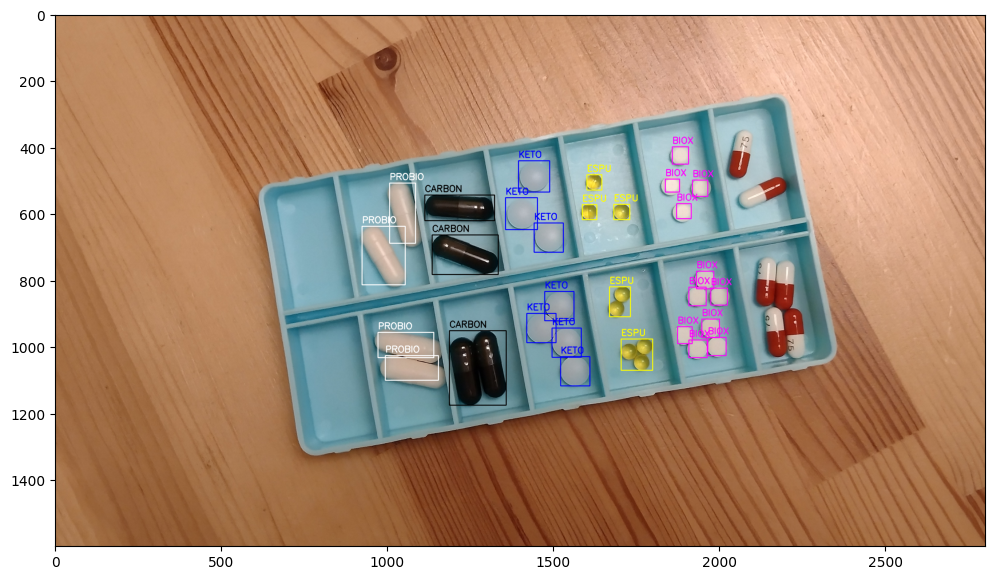

In [145]:
found = detect_objects(calib)
display_objects(calib, found)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

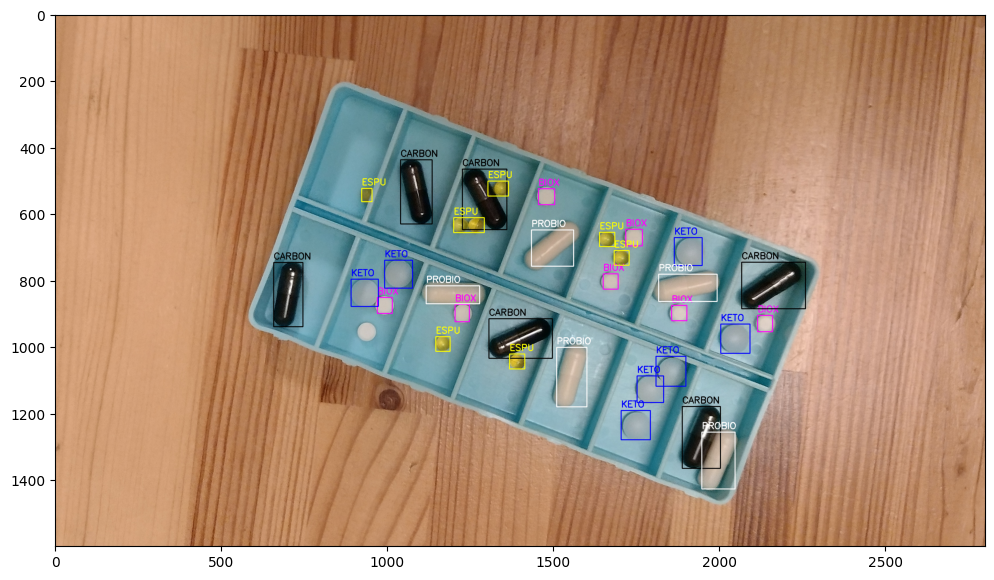

In [146]:
test = cv2.imread("test.png")
found = detect_objects(test)
display_objects(test, found)

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
żadne szczegóły implementacyjne tej struktury nie są narzucone.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.